# Seasonal ARIMA forecasting on PV

## Import data

In [160]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np

from sktime.forecasting.arima import ARIMA

import DataRetriever as dr

retriever = dr.DataRetriever()
year1 = retriever.get_data("All-Subsystems-hour-Year1.pkl")
year2 = retriever.get_data("All-Subsystems-hour-Year2.pkl")

In [161]:
gen_year1 = year1[year1["PV_Watts3PhTotalW3PhT1"].isna() == False]
gen_year1 = gen_year1[gen_year1["PV_Watts3PhTotalW3PhT2"].isna() == False] #There are 87 rows with NaN values.

print(f"A total of {len(year1) - len(gen_year1)} rows have been dropped since they have NaN values.")

gen_year1["Generated Energy"] = (gen_year1["PV_Watts3PhTotalW3PhT1"].to_numpy() + gen_year1["PV_Watts3PhTotalW3PhT2"].to_numpy())
gen_year1 = gen_year1[["Generated Energy"]] / 1e3 #Convert Wh to kWh
gen_year1

A total of 89 rows have been dropped since they have NaN values.


,Generated Energy
Timestamp,
2013-07-01 00:00:00,0.018507
2013-07-01 01:00:00,0.018495
2013-07-01 02:00:00,0.018376
2013-07-01 03:00:00,0.018470
2013-07-01 04:00:00,0.018339
...,...
2014-06-30 20:00:00,0.042880
2014-06-30 21:00:00,0.018101
2014-06-30 22:00:00,0.018410


In [162]:
gen_year2 = year2[year2["PV_Watts3PhTotalW3PhT1"].isna() == False]
gen_year2 = gen_year2[gen_year2["PV_Watts3PhTotalW3PhT2"].isna() == False] #There are 87 rows with NaN values.

print(f"A total of {len(year2) - len(gen_year2)} rows have been dropped since they have NaN values.")

gen_year2["Generated Energy"] = (gen_year2["PV_Watts3PhTotalW3PhT1"].to_numpy() + gen_year2["PV_Watts3PhTotalW3PhT2"].to_numpy())
gen_year2 = gen_year2[["Generated Energy"]] / 1e3 #Convert Wh to kWh
gen_year2

A total of 87 rows have been dropped since they have NaN values.


,Generated Energy
Timestamp,
2015-02-01 00:00:00,0.018496
2015-02-01 01:00:00,0.018332
2015-02-01 02:00:00,0.018385
2015-02-01 03:00:00,0.018502
2015-02-01 04:00:00,0.018524
...,...
2016-01-31 19:00:00,0.017710
2016-01-31 20:00:00,0.017940
2016-01-31 21:00:00,0.018149


In [163]:
# gen_df = pd.concat([gen_year1, gen_year2])
# gen_df

In [164]:
gen_df = gen_year2

gen_df = gen_df.resample('d').sum()
gen_df

,Generated Energy
Timestamp,
2015-02-01,12.958986
2015-02-02,0.010302
2015-02-03,41.425352
2015-02-04,40.553641
2015-02-05,42.718180
...,...
2016-01-27,33.832924
2016-01-28,43.440532
2016-01-29,27.944539


In [165]:
fig = go.Figure(go.Scattergl(
    x = gen_df.index,
    y = gen_df["Generated Energy"]
))

fig.show()

## Check if PV is stationary

In [166]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(gen_df["Generated Energy"])

print(f"The p-value from the Augmented Dickey-Fuller test is {test[1]}")

The p-value from the Augmented Dickey-Fuller test is 0.3079334389281078


In [167]:
gen_df['1dif'] = gen_df["Generated Energy"] - gen_df["Generated Energy"].shift(1)

gen_df

,Generated Energy,1dif
Timestamp,,
2015-02-01,12.958986,NaN
2015-02-02,0.010302,-12.948684
2015-02-03,41.425352,41.415050
2015-02-04,40.553641,-0.871710
2015-02-05,42.718180,2.164539
...,...,...
2016-01-27,33.832924,31.094507
2016-01-28,43.440532,9.607607
2016-01-29,27.944539,-15.495992


In [168]:
fig = go.Figure(go.Scattergl(
    x = gen_df.index,
    y = gen_df['1dif']
))

fig.show()

In [169]:
test = adfuller(gen_df["1dif"].dropna())

print(f"The p-value from the Augmented Dickey-Fuller test is {test[1]}.\nThis suggest d=1")

The p-value from the Augmented Dickey-Fuller test is 2.6380219612518528e-18.
This suggest d=1


## Calculate seasonal difference

In [191]:
# We have 4 quarters over the year

gen_df["Seasonal Difference"] = gen_df["Generated Energy"] - gen_df["Generated Energy"].shift(2)
gen_df

,Generated Energy,1dif,Seasonal Difference
Timestamp,,,
2015-02-01,12.958986,NaN,NaN
2015-02-02,0.010302,-12.948684,NaN
2015-02-03,41.425352,41.415050,28.466366
2015-02-04,40.553641,-0.871710,40.543340
2015-02-05,42.718180,2.164539,1.292829
...,...,...,...
2016-01-27,33.832924,31.094507,29.731483
2016-01-28,43.440532,9.607607,40.702114
2016-01-29,27.944539,-15.495992,-5.888385


In [192]:
fig = go.Figure(go.Scatter(
    x = gen_df.index,
    y = gen_df["Seasonal Difference"]
))

fig.show()

In [193]:
test = adfuller(gen_df["Seasonal Difference"].dropna())

print(f"The p value for the seasonal difference is {test[1]}.\nThis suggest D=0.")

The p value for the seasonal difference is 2.996048726017809e-11.
This suggest D=0.


## Autocorrelation & Partial Autocorrelation

In [194]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### First difference (d)

c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



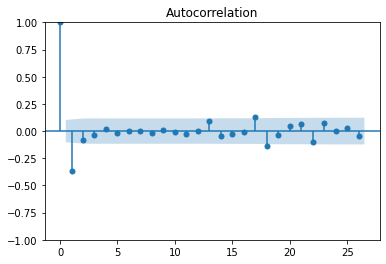

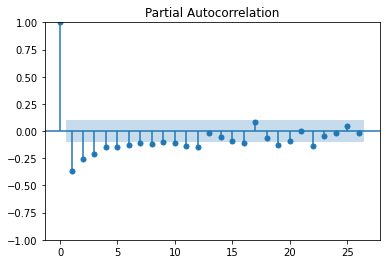

In [195]:
autocorrelation_first_difference = plot_acf(gen_df["1dif"].dropna())

partialautocorrelation_first_difference = plot_pacf(gen_df['1dif'].dropna())

### Seasonal difference (D)

c:\users\magnu\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



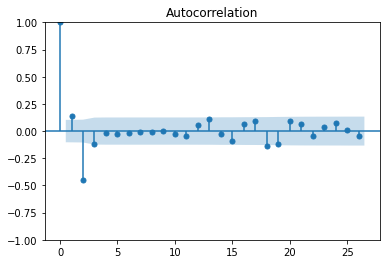

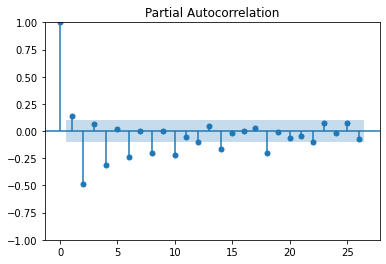

In [196]:
autocorrelation_seasonal_difference = plot_acf(gen_df["Seasonal Difference"].dropna())

partialautocorrelation_seasonal_difference = plot_pacf(gen_df['Seasonal Difference'].dropna())

## ARIMA model

In [197]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(gen_df["Generated Energy"], order=(1, 1, 1), seasonal_order=(0, 0, 0, 2))
result=model.fit()

<AxesSubplot:ylabel='Density'>

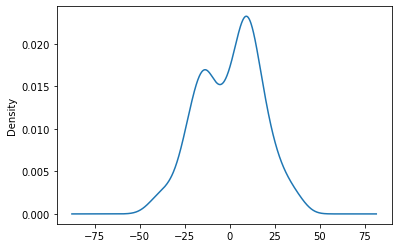

In [198]:
result.resid.plot(kind='kde')

### Forecasting

In [199]:
from pandas.tseries.offsets import DateOffset

new_dates = [gen_df.index[-1]+DateOffset(days=x) for x in range(1, 100) ]
new_dates

[Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-02-02 00:00:00'),
 Timestamp('2016-02-03 00:00:00'),
 Timestamp('2016-02-04 00:00:00'),
 Timestamp('2016-02-05 00:00:00'),
 Timestamp('2016-02-06 00:00:00'),
 Timestamp('2016-02-07 00:00:00'),
 Timestamp('2016-02-08 00:00:00'),
 Timestamp('2016-02-09 00:00:00'),
 Timestamp('2016-02-10 00:00:00'),
 Timestamp('2016-02-11 00:00:00'),
 Timestamp('2016-02-12 00:00:00'),
 Timestamp('2016-02-13 00:00:00'),
 Timestamp('2016-02-14 00:00:00'),
 Timestamp('2016-02-15 00:00:00'),
 Timestamp('2016-02-16 00:00:00'),
 Timestamp('2016-02-17 00:00:00'),
 Timestamp('2016-02-18 00:00:00'),
 Timestamp('2016-02-19 00:00:00'),
 Timestamp('2016-02-20 00:00:00'),
 Timestamp('2016-02-21 00:00:00'),
 Timestamp('2016-02-22 00:00:00'),
 Timestamp('2016-02-23 00:00:00'),
 Timestamp('2016-02-24 00:00:00'),
 Timestamp('2016-02-25 00:00:00'),
 Timestamp('2016-02-26 00:00:00'),
 Timestamp('2016-02-27 00:00:00'),
 Timestamp('2016-02-28 00:00:00'),
 Timestamp('2016-02-

In [200]:
gen_df_predict = pd.DataFrame(index=new_dates, columns=gen_df.columns)
gen_df_predict

,Generated Energy,1dif,Seasonal Difference
2016-02-01,NaN,NaN,NaN
2016-02-02,NaN,NaN,NaN
2016-02-03,NaN,NaN,NaN
2016-02-04,NaN,NaN,NaN
2016-02-05,NaN,NaN,NaN
...,...,...,...
2016-05-05,NaN,NaN,NaN
2016-05-06,NaN,NaN,NaN
2016-05-07,NaN,NaN,NaN
2016-05-08,NaN,NaN,NaN


In [201]:
test_df = pd.concat([gen_df, gen_df_predict])
test_df

,Generated Energy,1dif,Seasonal Difference
2015-02-01,12.958986,NaN,NaN
2015-02-02,0.010302,-12.948684,NaN
2015-02-03,41.425352,41.41505,28.466366
2015-02-04,40.553641,-0.87171,40.54334
2015-02-05,42.71818,2.164539,1.292829
...,...,...,...
2016-05-05,NaN,NaN,NaN
2016-05-06,NaN,NaN,NaN
2016-05-07,NaN,NaN,NaN
2016-05-08,NaN,NaN,NaN


In [202]:
test_df['Prediction'] = result.predict(start=365, end=464)
test_df

,Generated Energy,1dif,Seasonal Difference,Prediction
2015-02-01,12.958986,NaN,NaN,NaN
2015-02-02,0.010302,-12.948684,NaN,NaN
2015-02-03,41.425352,41.41505,28.466366,NaN
2015-02-04,40.553641,-0.87171,40.54334,NaN
2015-02-05,42.71818,2.164539,1.292829,NaN
...,...,...,...,...
2016-05-05,NaN,NaN,NaN,24.690789
2016-05-06,NaN,NaN,NaN,24.690789
2016-05-07,NaN,NaN,NaN,24.690789
2016-05-08,NaN,NaN,NaN,24.690789


<AxesSubplot:>

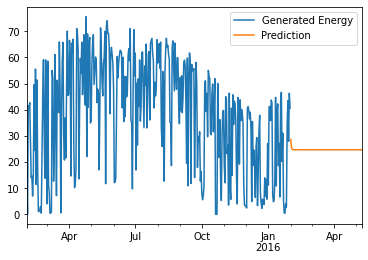

In [203]:
test_df[['Generated Energy', 'Prediction']].plot()